In [39]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.drawing.image import Image
import io
from datetime import datetime

In [4]:
tickers = ['O', 'MCD', 'JNJ']

In [5]:
data = yf.download(tickers, start = "2020-01-01", end="2023-01-01")['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [7]:
returns = data.pct_change()

In [41]:
returns

Ticker,JNJ,MCD,O
Date,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,-0.011578,-0.003536,0.018074
2020-01-06,-0.001248,0.011246,0.005014
2020-01-07,0.006107,0.001483,0.000269
2020-01-08,-0.000138,0.016187,0.004583
...,...,...,...
2022-12-23,0.002542,0.006773,0.015130
2022-12-27,-0.000282,-0.002728,-0.004658
2022-12-28,-0.004340,-0.006483,-0.013727


In [9]:
cumulative_returns = (1+returns).cumprod()

In [10]:
cumulative_returns

Ticker,JNJ,MCD,O
Date,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,0.988422,0.996464,1.018074
2020-01-06,0.987189,1.007670,1.023179
2020-01-07,0.993218,1.009164,1.023454
2020-01-08,0.993081,1.025499,1.028145
...,...,...,...
2022-12-23,1.314036,1.428396,1.043047
2022-12-27,1.313666,1.424499,1.038189
2022-12-28,1.307965,1.415263,1.023938


In [19]:
dividends = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    dividends[ticker] = stock.dividends

In [42]:
for ticker in tickers:
    if not dividends[ticker].empty:
        div_returns = dividends[ticker].resample('D').ffill().pct_change().fillna(0)
        div_returns = div_returns.tz_localize(None)
        returns[ticker] += div_returns
        cumulative_returns[ticker] = (1 + returns[ticker]).cumprod()

In [45]:
moving_avg = data.rolling(window=50).mean()

In [46]:
moving_avg

Ticker,JNJ,MCD,O
Date,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN
...,...,...,...
2022-12-23,161.907943,253.913778,55.213575
2022-12-27,162.169727,254.389194,55.373009
2022-12-28,162.377635,254.769088,55.482647


In [28]:
monthly_dividends = pd.DataFrame(dividends).resample('ME').sum()
yearly_dividends = pd.DataFrame(dividends).resample('YE').sum()
yearly_dividends

,O,MCD,JNJ
Date,,,
1962-12-31 00:00:00-05:00,0.000000,0.00,0.002316
1963-12-31 00:00:00-05:00,0.000000,0.00,0.002547
1964-12-31 00:00:00-05:00,0.000000,0.00,0.002779
1965-12-31 00:00:00-05:00,0.000000,0.00,0.003355
1966-12-31 00:00:00-05:00,0.000000,0.00,0.003819
...,...,...,...
2021-12-31 00:00:00-05:00,2.774975,5.25,4.190000
2022-12-31 00:00:00-05:00,2.972000,5.66,4.450000
2023-12-31 00:00:00-05:00,3.062000,6.23,4.700000


In [48]:
wb = Workbook()
ws = wb.active
ws.title = "Stock Data"

def make_index_naive(df):
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    return df

data = make_index_naive(data)
cumulative_returns = make_index_naive(cumulative_returns)
moving_avg = make_index_naive(moving_avg)
monthly_dividends = make_index_naive(monthly_dividends)
yearly_dividends = make_index_naive(yearly_dividends)

ws.append(['Date'] + tickers)
for index, row in data.iterrows():
    ws.append([index] + list(row))

ws_returns = wb.create_sheet("Cumulative Returns")
ws_returns.append(['Date'] + tickers)
for index, row in cumulative_returns.iterrows():
    ws_returns.append([index] + list(row))

ws_ma = wb.create_sheet("Moving Averages")
ws_ma.append(['Date'] + tickers)
for index, row in moving_avg.iterrows():
    ws_ma.append([index] + list(row))

ws_monthly_div = wb.create_sheet("Monthly Dividends")
ws_monthly_div.append(['Date'] + tickers)
for index, row in monthly_dividends.iterrows():
    ws_monthly_div.append([index] + list(row))

ws_yearly_div = wb.create_sheet("Yearly Dividends")
ws_yearly_div.append(['Date'] + tickers)
for index, row in yearly_dividends.iterrows():
    ws_yearly_div.append([index] + list(row))

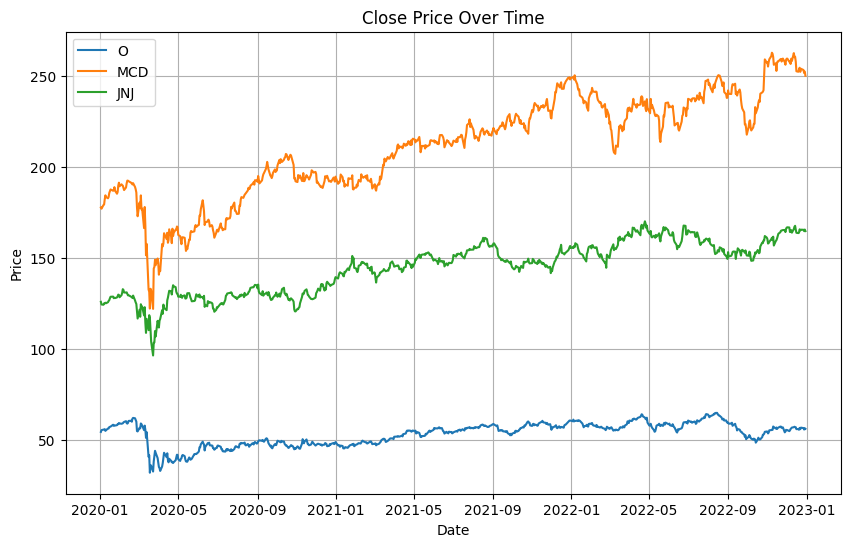

In [49]:
plt.figure(figsize=(10, 6))

for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)
    
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

img_data = io.BytesIO()
plt.savefig(img_data, format='png')
img_data.seek(0)

img = Image(img_data)
ws.add_image(img, 'E5')

In [50]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
report_name = f'{timestamp}__Stock_Analysis.xlsx'
wb.save(report_name)
print(f"Excel file is saved as {report_name}")

Excel file is saved as 20250323_124246__Stock_Analysis.xlsx
